文件使用： 
 
phase文件夹：  
cam0_2_{i}.bmp，i=0,1,2,...,11，表示左相机12步相移法投射的12幅相移图像。  
cam1_2_{i}.bmp，i=0,1,2,...,11，表示右相机12步相移法投射的12幅相移图像。  
cam0_2_21.bmp，cam0_2_22.bmp，cam1_2_21.bmp，cam1_2_22.bmp，表示左相机和右相机的黑白辅助图像。  
cam0_2_12.bmp，cam1_2_12.bmp，表示左相机和右相机的互补格雷码图像。  
cam0_2_{i}.bmp，cam1_2_{i}.bmp，i=12,13,14,...,20，表示左相机和右相机的格雷码图像。

calib文件夹：  
cam0_{i}.bmp，cam1_{i}.bmp，i=0,1,2,...,9，表示左相机和右相机的标定板图像，主要用于在matlab中标定获得相机参数。

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

# TODO 1: 双目标定

这一步的参数可以由matlab算出，这里直接根据项目给出。

In [2]:
# 单位都为像素
# 内参 - 左相机内参
mtx_left= np.array([
    [3521.19066,  0, 1246.75514],
    [0, 3520.56746, 1060.11120],
    [0,  0,  1]
], dtype=float) #[0,0]是相机x轴焦距，[1,1]是相机y轴焦距，[0,2]是相机x轴主点，[1,2]是相机y轴主点。

# 内参 - 左相机畸变系数
dist_left= np.array([[ -0.05778, 0.30358, -0.00034, 0.00015, 0.00000 ]], dtype=float)
    # 1.dist_left[0](-0.05778): 第一径向畸变系数（k_1）。这个值为负值，表示存在桶形畸变（图像中心向外膨胀）。
    # 2.dist_left[1](0.30358): 第二径向畸变系数（k_2）。这个值表示图像的畸变程度。
    # 3.dist_left[2](-0.00034): 第三径向畸变系数（k_3）。这个值通常对高畸变镜头重要。
    # 4.dist_left[3](0.00015): 切向畸变系数（p_1）。表示镜头与图像平面之间的非对称性，通常与对焦或传感器位置不准确有关。
    # 5.dist_left[4](0.00000): 切向畸变系数（p_2）。这个值表示另一种切向畸变，通常与第一个切向畸变系数一起使用。

# 内参 - 右相机内参
mtx_right= np.array([
    [3530.87538,  0, 1216.98580],
    [ 0, 3529.95453, 1036.35111],
    [ 0,  0,  1]
], dtype=float)

# 内参 - 右相机畸变系数
dist_right= np.array([[ -0.04209, 0.20062 , 0.00002, -0.00104, 0.00000 ]], dtype=float)

# 外参 - 左相机到右相机的旋转矩阵
om = np.array([0.00772, 0.56250, 0.01798], dtype=float) # matlab解出的右手坐标系

# 将旋转向量转换为旋转矩阵
R, _ = cv2.Rodrigues(om)
print('3*3的旋转矩阵', R)

# 外参 - 左相机到右相机的平移矩阵
T = np.array([[-207.17271], [3.40873], [57.93334]], dtype=float)  # 列向量

3*3的旋转矩阵 [[ 0.84577202 -0.01493108  0.53333549]
 [ 0.01916015  0.99981356 -0.00239403]
 [-0.53320031  0.01224359  0.84590042]]


根据相机内外参数，计算极线校正后的映射（也就是原来的畸形的图像转化为正确的图像，坐标如何变换）。我们读取一对双目图像验证计算得到的映射是否正确，如果正确，会发现3d物体的同一个位置在左右图像中对应的2d像素点所形成极线是同一条直线。

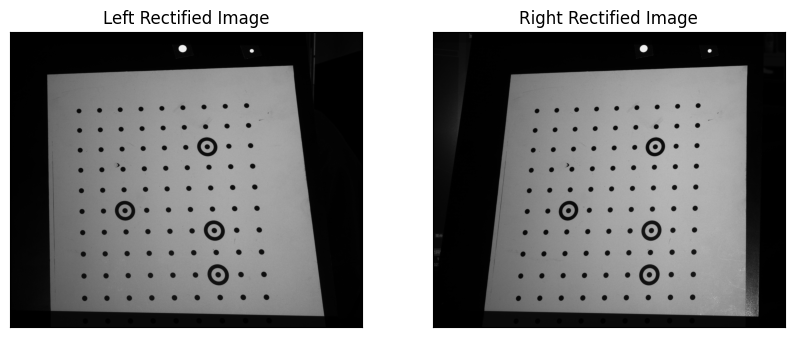

In [3]:
# 极线校正
imageSize = (2448, 2048)
    # R1，R2：左右相机的旋转矩阵，用于将图像对齐到校正后的坐标系。
    # P1，P2：新的投影矩阵，包含内参和校正后的外参。
    # Q：用于将视差图转换为三维点云的矩阵。
    # validPixROI1，alidPixROI2：校正后图像中有效像素区域的边界框。
R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(
    mtx_left, dist_left,
    mtx_right, dist_right,
    imageSize, R, T,
    flags=cv2.CALIB_FIX_INTRINSIC,
    alpha=0
)

# 计算校正映射：这两个映射分别表示x和y方向的坐标变换，4个映射可以用于将左右原始图像的像素位置重新映射到校正后的图像上。
map1_x, map1_y = cv2.initUndistortRectifyMap(mtx_left, dist_left, R1, P1, imageSize, cv2.CV_32FC1)
map2_x, map2_y = cv2.initUndistortRectifyMap(mtx_right, dist_right, R2, P2, imageSize, cv2.CV_32FC1)

# 读取一对双目图像查看极线矫正效果
left_img = cv2.imread('data/calib/1/cam0_1.bmp')  # 左图
right_img = cv2.imread('data/calib/1/cam1_1.bmp')  # 右图

# 矫正图像
left_rectified = cv2.remap(left_img, map1_x, map1_y, cv2.INTER_LINEAR)
right_rectified = cv2.remap(right_img, map2_x, map2_y, cv2.INTER_LINEAR)

# 显示极线矫正后的图像
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB))
plt.title('Left Rectified Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(right_rectified, cv2.COLOR_BGR2RGB))
plt.title('Right Rectified Image'), plt.xticks([]), plt.yticks([])
plt.show()

# TODO 2: 解展开相位
根据相移法和互补格雷码法解出展开相位，并对相位图进行极线矫正。

## 相移法得到包裹相位wrapped phase
在实际操作中，一般通过投影仪投射并采集变形条纹，再使用双目相机拍摄。  
常见的4步相移法中，每一步投射相位彼此相差 90∘ 的条纹图案，生成不同的条纹图像。通过这几幅相移图像，可以计算出每个像素的相位值。  
本项目使用12步相移法，每一步投射相位彼此相差 30∘ 的条纹图案。  
### 4步相移法公式：
φ(x, y) = arctan((I_4 - I_2) / (I_1 - I_3))  
其中，I_1, I_2, I_3, I_4分别表示在不同相移下采集的图像灰度值，φ(x, y)为相位值。
### 12步相移法公式：
A = (2 / 12) * Σ[k=0 to 11] I_k * cos(2πk / 12)  
B = (2 / 12) * Σ[k=0 to 11] I_k * sin(2πk / 12)  
φ(x, y) = arctan(B / A)  
其中，I_k表示第k幅图像的灰度值，φ(x, y)为相位值。

In [4]:
def compute_phase(images):
    """通过相移法得到包裹相位，并将相位范围从 [-π, π] 转换到 [0, 2π]"""
    if len(images) != 12:
        raise ValueError("必须提供 12 张相位图")

    # 初始化复数相位图
    phase_complex = np.zeros(images[0].shape, dtype=np.complex128)
    # 计算复数相位图
    for i in range(12):
        phase_complex += images[i] * np.exp(2j * np.pi * i / 12)
    # 使用 arctan2 提取相位，初始范围 [-π, π]
    wrapped_phase0 = np.arctan2(phase_complex.imag, phase_complex.real).astype(np.float32)
    # 将相位转换到 [0, 2π] 范围
    wrapped_phase = np.where(wrapped_phase0 < 0, wrapped_phase0 + 2 * np.pi, wrapped_phase0)

    return wrapped_phase

## 格雷码解码
这一步是为了得到unwrapped phase。  
在三维重建中，格雷码用于对物体的图像进行区域划分，并将不同的区域标记为不同的编码值。在本实验中，格雷码与相移条纹结合，将图像分割为多个子区域，再利用相位展开技术计算绝对相位。  
本项目中格雷码的解码过程包括以下几个步骤：
1. 从格雷码图像中解出 k1 值，并将其转换为二进制数。
2. 使用黑白辅助图像来确定格雷码的动态二值化阈值。
3. 根据互补格雷码 (GC9) 计算 k2。
4. 利用格雷码、互补格雷码和黑白辅助图像进行相位展开。

In [5]:
def decode_gray_code(gray_codes, black_white_images):
    """
    从格雷码图像中解出 k1 值，并将其转换为二进制数。
    使用黑白辅助图像来确定格雷码的动态二值化阈值。
    """
    height, width = gray_codes[0].shape
    k1_binary = np.zeros((height, width), dtype=np.int32)  # 用于存储解码后的二进制结果

    # 动态二值化阈值
    # threshold = (black_white_images[0] + black_white_images[1]) / 2
    threshold = 0.4

    # 使用第一张格雷码图像作为初始的二进制数最高位 B_1 = G_1
    k1_binary = (gray_codes[0] > threshold).astype(np.int32)

    # 从第二张格雷码图像开始，逐位进行二进制转换
    for i in range(1, len(gray_codes)):
        # 当前格雷码图像的二值化结果
        current_gray_code = (gray_codes[i] > threshold).astype(np.int32)

        # 只取 k1_binary 的最后一位，并与当前格雷码位进行异或
        last_bit = k1_binary & 1  # 取 k1_binary 的最低有效位
        new_bit = last_bit ^ current_gray_code  # 计算当前格雷码位与最低有效位的异或结果

        # 将 k1_binary 左移一位，为下一位腾出空间
        k1_binary = k1_binary << 1

        # 将异或后的结果拼接到最低位
        k1_binary = k1_binary | new_bit

    return k1_binary


def phase_unwrapping(wrapped_phase, k1, k2):
    """利用k1, k2和黑白辅助图像进行相位展开"""
    height, width = wrapped_phase.shape
    unwrapped_phase = np.zeros((height, width), dtype=np.float32)

    for y in range(height):
        for x in range(width):
            # 相位展开，依据不同的相位范围选择不同的修正公式
            # 格雷码有可能超前或者滞后，所以需要修正
            phi = wrapped_phase[y, x]
            if phi <= np.pi / 2:
                unwrapped_phase[y, x] = phi + 2 * np.pi * k2[y, x]
            elif np.pi / 2 < phi < 3 * np.pi / 2:
                unwrapped_phase[y, x] = phi + 2 * np.pi * k1[y, x]
            else:
                unwrapped_phase[y, x] = phi + 2 * np.pi * (k2[y, x] - 1)

    return unwrapped_phase

## 极线校正
这一步是为了将相位图矫正到极线对齐。  
极线校正后的相位图可以用于计算视差图，进而得到三维点云。  

In [6]:
def rectify_phase(unwrapped_phase, map1, map2):
    """
    矫正相位图，使其满足极线对齐。
    参数:
        unwrapped_phase (ndarray): 解包裹后的相位图。
        map1, map2 (ndarray): initUndistortRectifyMap返回的映射。
    返回:
        rectified_phase (ndarray): 矫正后的相位图。
    """
    rectified_phase = cv2.remap(unwrapped_phase, map1, map2, cv2.INTER_LINEAR)
    return rectified_phase

In [7]:
# 读取相移图像
images_left = [cv2.imread(f'data/phase/L/cam0_2_{i}.bmp', cv2.IMREAD_GRAYSCALE) / 255.0 for i in range(12)]
images_right = [cv2.imread(f'data/phase/R/cam1_2_{i}.bmp', cv2.IMREAD_GRAYSCALE) / 255.0 for i in range(12)]

# 解包裹相位
wrapped_phase_left = compute_phase(images_left)
wrapped_phase_right = compute_phase(images_right)

# 读取8张格雷码图像 (GC1 到 GC8)
gray_codes_left = [cv2.imread(f'data/phase/L/cam0_2_{20 - i}.bmp', cv2.IMREAD_GRAYSCALE) / 255.0 for i in range(8)]
gray_codes_right = [cv2.imread(f'data/phase/R/cam1_2_{20 - i}.bmp', cv2.IMREAD_GRAYSCALE) / 255.0 for i in range(8)]

# 读取互补格雷码 (GC9)
gray_code_complement_left = cv2.imread('data/phase/L/cam0_2_12.bmp', cv2.IMREAD_GRAYSCALE) / 255.0
gray_code_complement_right = cv2.imread('data/phase/R/cam1_2_12.bmp', cv2.IMREAD_GRAYSCALE) / 255.0

# 读取黑白辅助图像，用于动态二值化
black_white_left = [
    cv2.imread('data/phase/L/cam0_2_21.bmp', cv2.IMREAD_GRAYSCALE) / 255.0,
    cv2.imread('data/phase/L/cam0_2_22.bmp', cv2.IMREAD_GRAYSCALE) / 255.0
]
black_white_right = [
    cv2.imread('data/phase/R/cam1_2_21.bmp', cv2.IMREAD_GRAYSCALE) / 255.0,
    cv2.imread('data/phase/R/cam1_2_22.bmp', cv2.IMREAD_GRAYSCALE) / 255.0
]

# 解码格雷码 (GC1 到 GC8)，使用黑白辅助图像确定阈值
k1_left = decode_gray_code(gray_codes_left, black_white_left)
k1_right = decode_gray_code(gray_codes_right, black_white_right)

# 根据互补格雷码 (GC9) 计算 k2
k2_left = k1_left.copy()
k2_right = k1_right.copy()

# 若互补格雷码为1，则 k2 = k1，否则 k2 - 1
k2_left[gray_code_complement_left > 0.5] = k1_left[gray_code_complement_left > 0.5]
k2_right[gray_code_complement_right > 0.5] = k1_right[gray_code_complement_right > 0.5]

# 利用格雷码、互补格雷码和黑白辅助图像进行相位展开
unwrapped_phase_left = phase_unwrapping(wrapped_phase_left, k1_left, k2_left)
unwrapped_phase_right = phase_unwrapping(wrapped_phase_right, k1_right, k2_right)

# 映射相位到0-255
unwrapped_phase_left_display = (unwrapped_phase_left / (256 * np.pi) * 255).astype(np.uint8)
unwrapped_phase_right_display = (unwrapped_phase_right/ (256 * np.pi) * 255).astype(np.uint8)

# 极线校正绝对相位图的主程序
unwrapped_phase_left_rectified = rectify_phase(unwrapped_phase_left_display, map1_x, map1_y)
unwrapped_phase_right_rectified = rectify_phase(unwrapped_phase_right_display, map2_x, map2_y)

# 展示由十二步相移法解出的相对相位display
wrapped_phase_left_display = (wrapped_phase_left / (2 * np.pi) * 255).astype(np.uint8)
wrapped_phase_right_display = (wrapped_phase_right / (2 * np.pi) * 255).astype(np.uint8)

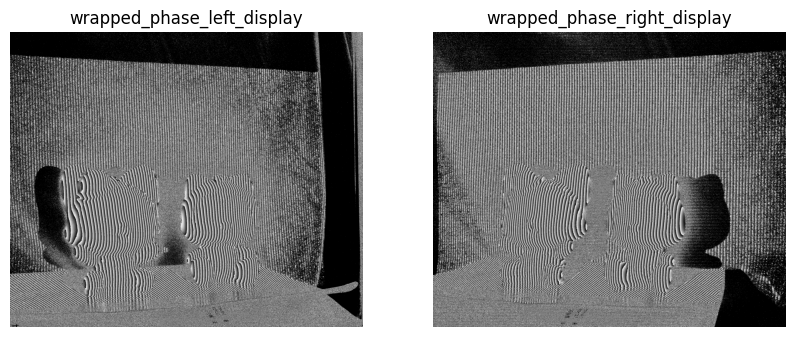

In [8]:
# 展示由十二步相移法解出的相对相位
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wrapped_phase_left_display, cmap='gray')
plt.title('wrapped_phase_left_display')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wrapped_phase_right_display, cmap='gray')
plt.title('wrapped_phase_right_display')
plt.axis('off')

plt.show()

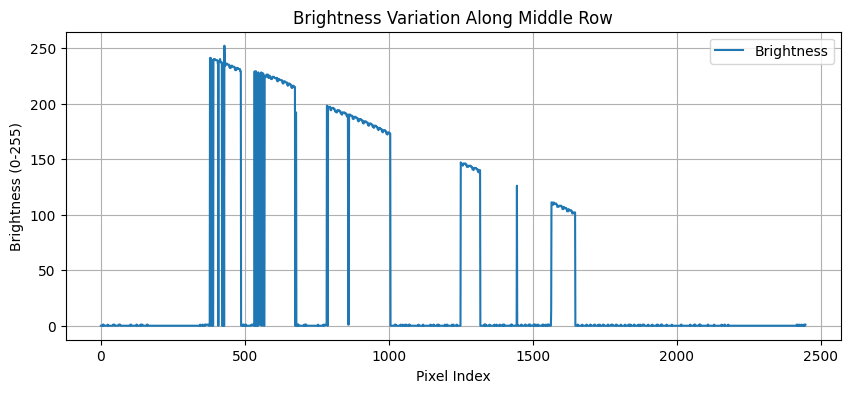

In [9]:
# 取最终绝对相位图的中间某一行，绘制相位变化图
plt.figure(figsize=(10, 4))
plt.plot(unwrapped_phase_left_display[1000, :], label='Brightness')
plt.title('Brightness Variation Along Middle Row')
plt.xlabel('Pixel Index')
plt.ylabel('Brightness (0-255)')
plt.legend()
plt.grid(True)
plt.show()

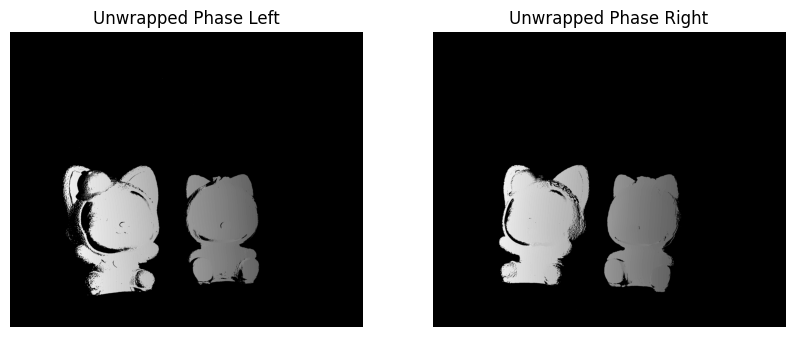

In [10]:
# 显示解相位后的图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(unwrapped_phase_left_display, cmap='gray')
plt.title('Unwrapped Phase Left')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(unwrapped_phase_right_display, cmap='gray')
plt.title('Unwrapped Phase Right')
plt.axis('off')

plt.show()

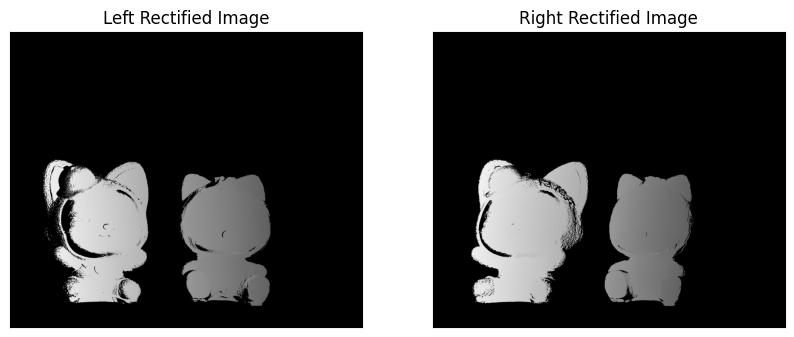

In [11]:
# 显示极线矫正后的图像
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(cv2.cvtColor(unwrapped_phase_left_rectified, cv2.COLOR_BGR2RGB))
plt.title('Left Rectified Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(unwrapped_phase_right_rectified, cv2.COLOR_BGR2RGB))
plt.title('Right Rectified Image'), plt.xticks([]), plt.yticks([])
plt.show()

# TODO 3: 3d重建
双目匹配，进行3D点云重建。  
主要原理是：对于3d物体同一位置，它在左右相机中对应着一对2d像素点，这对像素点理论上具有相同的绝对相位值，并且落在极线上。

In [12]:
# 为了相位值匹配的差值作准备，防止+-差值后溢出
unwrapped_phase_left_rectified = unwrapped_phase_left_rectified.astype(np.int32)
unwrapped_phase_right_rectified = unwrapped_phase_right_rectified.astype(np.int32)

height, width = unwrapped_phase_left_rectified.shape

# 用于存储匹配点的列表
corresponding_points_left = []
corresponding_points_right = []

# 设置匹配参数：双指针，通过左指针和右滑动窗口寻找匹配相位值(考虑了噪声)
threshold = 3  # 相位值差异5
window_size = 80  # 右侧滑动窗口大小50

# 遍历每一行
for y in range(height):
    # 获取当前行的左图和右图相位值
    left_phase = unwrapped_phase_left_rectified[y, :]
    right_phase = unwrapped_phase_right_rectified[y, :]

    # 提取非零且不为1的相位值对应的x索引
    left_indices = np.where((left_phase != 0) & (left_phase != 1))[0]
    right_indices = np.where((right_phase != 0) & (right_phase != 1))[0]

    # 提取对应的相位值
    left_phase_values = left_phase[left_indices]
    right_phase_values = right_phase[right_indices]

    # 初始化右指针
    right_pointer = 0
    len_right = len(right_phase_values)

    # 遍历左侧的相位值
    for i in range(len(left_phase_values)):
        left_val = left_phase_values[i] # 相位值
        left_x = left_indices[i] # 索引

        # 定义右侧滑动窗口的起始和结束位置
        window_start = right_pointer
        window_end = min(right_pointer + window_size, len_right)

        # 提取当前滑动窗口中的相位值和对应的x索引
        window = right_phase_values[window_start:window_end]
        window_x = right_indices[window_start:window_end]

        # 查找是否存在相位值与左侧相位值差异为threshold的匹配点
        match_indices = np.where((window == left_val + threshold) | (window == left_val - threshold))[0]

        if match_indices.size > 0:
            # 选择第一个匹配点
            match_idx = match_indices[0]
            matched_right_x = window_x[match_idx]
            matched_right_val = window[match_idx]

            # 存储匹配点
            corresponding_points_left.append([left_x, y, left_val])
            corresponding_points_right.append([matched_right_x, y, matched_right_val])

            # 更新右指针到匹配点的下一个位置
            right_pointer = window_start + match_idx + 1
        else:
            # 如果没有找到匹配点，左指针自动向下移动
            # 这里不需要显式移动左指针，因为for循环会自动进行
            pass

# 转换为 numpy 数组
corresponding_points_left = np.array(corresponding_points_left).T  # shape (3, n)
corresponding_points_right = np.array(corresponding_points_right).T  # shape (3, n)

# 输出匹配点信息
print('第一对匹配点的左点', corresponding_points_left[:,0])
print('第一对匹配点的右点', corresponding_points_right[:,0])
print('一共找到', corresponding_points_left.shape[1], '对匹配点')

第一对匹配点的左点 [325 887 159]
第一对匹配点的右点 [429 887 162]
一共找到 229033 对匹配点


In [13]:
corresponding_points_left = np.array(corresponding_points_left[:2],dtype=np.float32)
corresponding_points_right = np.array(corresponding_points_right[:2],dtype=np.float32)

points_4d_homogeneous = cv2.triangulatePoints(P1,P2,corresponding_points_left,corresponding_points_right)
points_3d = points_4d_homogeneous[:3,:] / points_4d_homogeneous[3,:]

points_3d = points_3d.T

In [ ]:
# 将 points_3d 转换为 numpy 数组
points_3d = np.array(points_3d)

# 创建一个 open3d 的 PointCloud 对象
point_cloud = o3d.geometry.PointCloud()

# 设置点云的坐标
point_cloud.points = o3d.utility.Vector3dVector(points_3d)

# 设置颜色，给每个点赋予相同的颜色，例如白色
colors = np.array([[0.8,0.8,0]])  # 白色 [1, 1, 1]
point_cloud.colors = o3d.utility.Vector3dVector(colors)

# 可视化点云
o3d.visualization.draw_geometries([point_cloud], window_name="3D Point Cloud", width=800, height=600)

![结果](/Users/checklevelmax/Documents/03 BS./01 3dVision/3D_Reconstruction/result.png)